# Comment utiliser les algorithmes avec votre similarité

In [1]:
#classification
from sklearn.neighbors import KNeighborsClassifier #k-plus proches voisins

#Partitionnement
from sklearn.cluster import AgglomerativeClustering #Regroupement hiérarchique (Paritionnement binaire)
from pyclustering.cluster.kmedoids import kmedoids

#réduction de dimensionnalité
from sklearn.decomposition import KernelPCA #ce n'est pas PCoA mais on peut l'utiliser pour que le résultat soit le même
from sklearn.manifold import Isomap

Ici, on utilisera la dissimilarité cosinus (1 - la similarité cosinus).

In [2]:
import numpy as np

def cosine_similarity(x, y, *args, **kwargs):
    return (x*y).sum(*args, **kwargs)/np.sqrt((x*x).sum(*args, **kwargs) * (y*y).sum(*args, **kwargs))

def cosine_dissimilarity(x, y, *args, **kwargs):
    return 1 - cosine_similarity(x, y, *args, **kwargs)

def get_cosine_dissimilarity_matrix(X, Y=None):
    Y = X if Y is None else Y
    return cosine_dissimilarity(X[:,None], Y[None,:], axis=2)

## Jeu de données

Je n'utiliserais pas MNIST et Adult pour des raisons évidentes. Nos données seront 123 points 2D qui forment un cercle.

circle.shape = (123, 2)


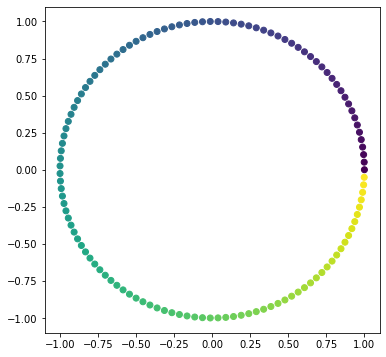

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
theta = np.linspace(0, 2*np.pi, 124)[:-1]
circle = np.stack([np.cos(theta), np.sin(theta)], axis=1)

print(f'circle.shape = {circle.shape}')
plt.figure(figsize=(6,6)).add_subplot(111).scatter(circle[:,0], circle[:,1], c=theta);

## Matrice de dissimilarité

Vous devez calculer la matrice de dissimilarité D. D[i,j] est la dissimilarité entre la donnée i et la donnée j. Ici, nous utiliserons la dissimilarité cosinus. C'est-à-dire 1 - la similarité cosinus. 

> Attention: pour certains algorithmes la matrice de dissimilarité doit être positive en chaque entrée. Définissez votre dissimilarité à partir de votre similarité de sorte qu'elle soit toujours positive.

circle_cosine_dissimilarity.shape = (123, 123)


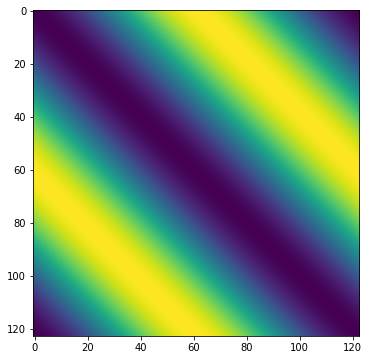

In [4]:
circle_cosine_dissimilarity = get_cosine_dissimilarity_matrix(circle)
print(f'circle_cosine_dissimilarity.shape = {circle_cosine_dissimilarity.shape}')
plt.figure(figsize=(6,6)).add_subplot(111).imshow(circle_cosine_dissimilarity);

In [5]:
i, j = 7, 42
print(circle_cosine_dissimilarity[i,j])
print(cosine_dissimilarity(circle[i], circle[j]))

1.2154004927989812
1.2154004927989812


## Généralisation sur l'ensemble teste

Pour tester les algorithmes "entraînés" nous devons utiliser un autre jeu de données (l'ensemble teste). Nos données test seront 99 points 2D formant le symbole d'infini.

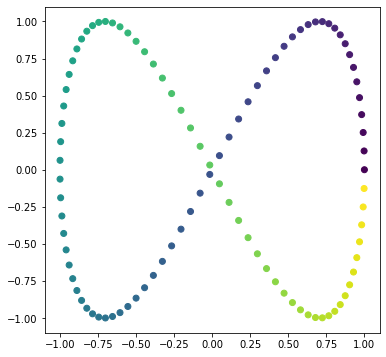

In [6]:
theta2 = np.linspace(0, 2*np.pi, 100)[:-1]
infinity = np.stack([np.cos(theta2), np.sin(2*theta2)], axis=1)
plt.figure(figsize=(6,6)).add_subplot(111).scatter(infinity[:,0], infinity[:,1], c=theta2);

## La matrice rectangulaire de dissimilarité

Si D est la matrice rectangulaire de dissimilarité. On a que D[i,j] est la dissimilarité entre la donnée i de l'ensemble **teste** (ici ```infinity```) et la donnée j de l'ensemble d'entraînement (ici ```circle```).

infinity_circle_cosine_dissimilarity.shape = (99, 123)


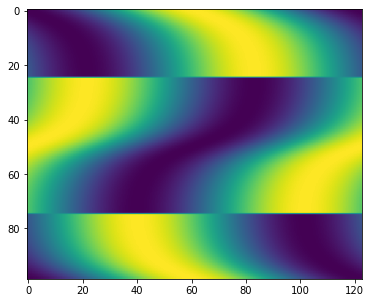

In [7]:
infinity_circle_cosine_dissimilarity = get_cosine_dissimilarity_matrix(infinity, circle)
print(f'infinity_circle_cosine_dissimilarity.shape = {infinity_circle_cosine_dissimilarity.shape}')
plt.figure(figsize=(6,6)).add_subplot(111).imshow(infinity_circle_cosine_dissimilarity);

In [8]:
i, j = 7, 42
print(infinity_circle_cosine_dissimilarity[i,j])
print(cosine_dissimilarity(infinity[i], circle[j]))

0.8650593253446653
0.8650593253446653


## Les algorithmes
Dans tous les cas, il faudra d'une façon ou d'une autre spécifier aux algorithmes que l'on va lui fournir une matrice de dissimilarité.

### Isomap

Utiliser ```fit``` sur l'ensemble d'entraînement et ```transform``` sur l'ensemble teste. On utilise ```metric='precomputed``` pour fournir une matrice de dissimilarité.

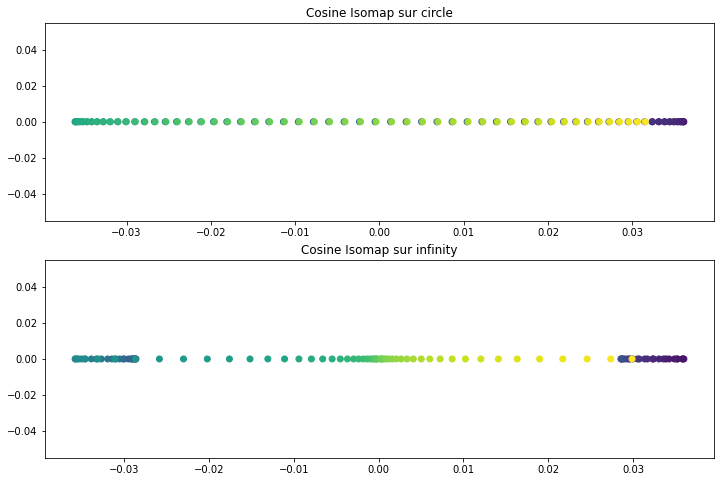

In [9]:
isomap = Isomap(n_components=1, n_neighbors=2, metric='precomputed')
isomap_circle = isomap.fit_transform(circle_cosine_dissimilarity)
isomap_infinity = isomap.transform(infinity_circle_cosine_dissimilarity)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
ax.set_title('Cosine Isomap sur circle')
ax.scatter(isomap_circle, np.zeros_like(isomap_circle), c=theta);

ax = fig.add_subplot(212)
ax.set_title('Cosine Isomap sur infinity')
ax.scatter(isomap_infinity, np.zeros_like(isomap_infinity), c=theta2);

### PCoA

On utilise KernelPCA, qui n'est pas équivalent à PCoA en général. Pour retrouver PCoA on doit utiliser ```kernel='precomputed```. De plus, on ne doit pas fournir la matrice de dissimilarité D directement. **Chaque élément de la matrice doit être au carré et multiplier par -0.5.**

Utiliser ```fit``` sur l'ensemble d'entraînement et ```transform``` sur l'ensemble teste.

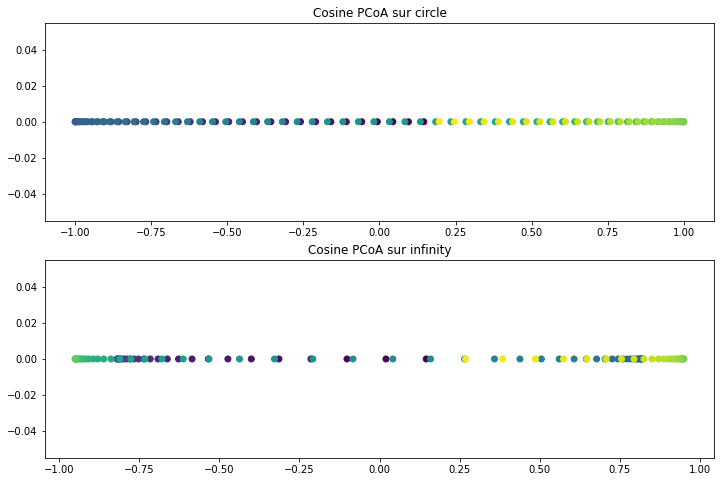

In [10]:
pcoa = KernelPCA(n_components=1, kernel='precomputed')
pcoa_circle = pcoa.fit_transform(-.5*circle_cosine_dissimilarity**2) #-.5*D**2 est crucial!!!
pcoa_infinity = pcoa.transform(-.5*infinity_circle_cosine_dissimilarity**2) #-.5*D**2 est crucial!!!

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
ax.set_title('Cosine PCoA sur circle')
ax.scatter(pcoa_circle, np.zeros_like(pcoa_circle), c=theta);

ax = fig.add_subplot(212)
ax.set_title('Cosine PCoA sur infinity')
ax.scatter(pcoa_infinity, np.zeros_like(pcoa_infinity), c=theta2);

### K-Médoids

On utilise ```data_type='distance_matrix'``` pour utiliser la matrice de dissimilarité. On doit fournir l'ensemble d'entraînement au constructeur et appeler ```proccess``` pour entraîner. Utiliser ```predict``` pour votre évaluation sur l'ensemble teste.

Les médoids sont les points avec les angles [4.44420424 2.29872633 0.20433123] (radian).


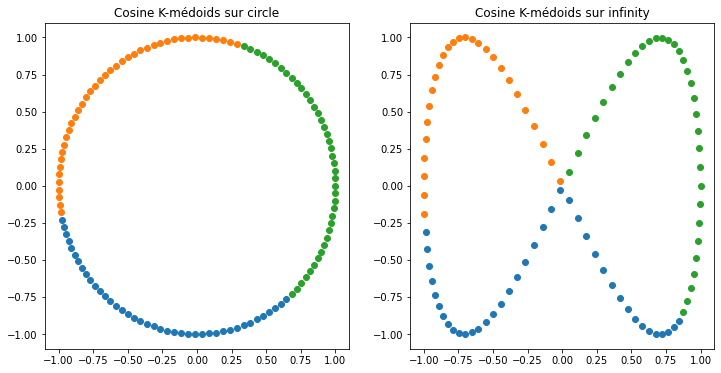

In [11]:
initial_medoids = [0,1,2]
kmedoids_instance = kmedoids(circle_cosine_dissimilarity, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process() #training

kmedoids_circle = kmedoids_instance.predict(circle_cosine_dissimilarity)
kmedoids_infinity = kmedoids_instance.predict(infinity_circle_cosine_dissimilarity)

print(f'Les médoids sont les points avec les angles {theta[kmedoids_instance.get_medoids()]} (radian).')
fig = plt.figure(figsize=(12, 6))
circle_ax = fig.add_subplot(121)
infinity_ax = fig.add_subplot(122)
circle_ax.set_title('Cosine K-médoids sur circle')
infinity_ax.set_title('Cosine K-médoids sur infinity')

for i in range(3):
    circle_cluster = circle[np.where(kmedoids_circle == i)[0]]
    circle_ax.scatter(circle_cluster[:, 0], circle_cluster[:, 1])
    
    infinity_cluster = infinity[np.where(kmedoids_infinity == i)[0]]
    infinity_ax.scatter(infinity_cluster[:, 0], infinity_cluster[:, 1])

### Regroupement hiérarchique (Paritionnement binaire)

Utiliser ```affinity='precomputed'``` et ```linkage='average'```. On utilise ```fit``` pour l'entraînement. ```AgglomerativeClustering``` ne fournit pas de méthode ```predict``` voici une implémentation simple qui retourne la partition ayant la dissimilarité moyenne la plus faible.

> Il y a d'autres façons non équivalentes de définir une prédiction. Si vous avez déjà implémenté une autre méthode vous pouvez l'utiliser.

In [12]:
def agglomerative_clustering_predict(agglomerative_clustering, dissimilarity_matrix):
    average_dissimilarity = list()
    for i in range(agglomerative_clustering.n_clusters):
        ith_clusters_dissimilarity = dissimilarity_matrix[:, np.where(agglomerative_clustering.labels_==i)[0]]
        average_dissimilarity.append(ith_clusters_dissimilarity.mean(axis=1))
    return np.argmin(np.stack(average_dissimilarity), axis=0)

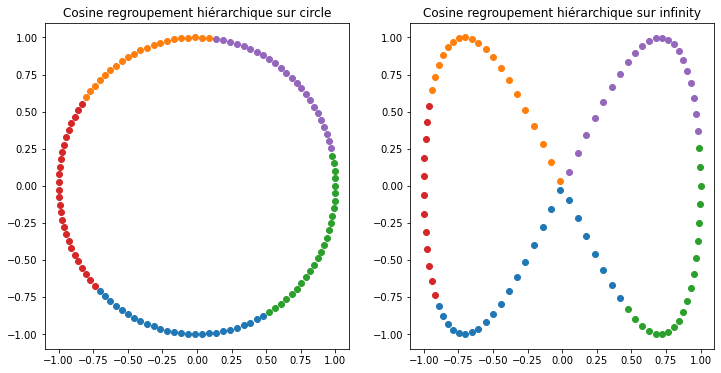

In [13]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='average')
agglomerative_clustering.fit(circle_cosine_dissimilarity)

agglo_circle = agglomerative_clustering_predict(agglomerative_clustering, circle_cosine_dissimilarity)
agglo_infinity = agglomerative_clustering_predict(agglomerative_clustering, infinity_circle_cosine_dissimilarity)

fig = plt.figure(figsize=(12, 6))
circle_ax = fig.add_subplot(121)
infinity_ax = fig.add_subplot(122)
circle_ax.set_title('Cosine regroupement hiérarchique sur circle')
infinity_ax.set_title('Cosine regroupement hiérarchique sur infinity')

for i in range(5):
    circle_cluster = circle[np.where(agglo_circle == i)[0]]
    circle_ax.scatter(circle_cluster[:, 0], circle_cluster[:, 1])
    
    infinity_cluster = infinity[np.where(agglo_infinity == i)[0]]
    infinity_ax.scatter(infinity_cluster[:, 0], infinity_cluster[:, 1])

### K-plus proches voisins

On utilise ```metric='precomputed'``` et ```algorithm='brute'```. Utiliser ```fit``` sur l'ensemble d'entraînement et ```predict``` sur l'ensemble teste.

In [14]:
#On doit définir un "target" pour l'algorithme de classification.
#Disons que le "target" est les quadrants du plan cartésien.
#0 en haut à gauche
#1 en haut à droite
#2 en bas à droite
#3 en bas à gauche
quadrants = (theta / (np.pi/2)).astype(int)

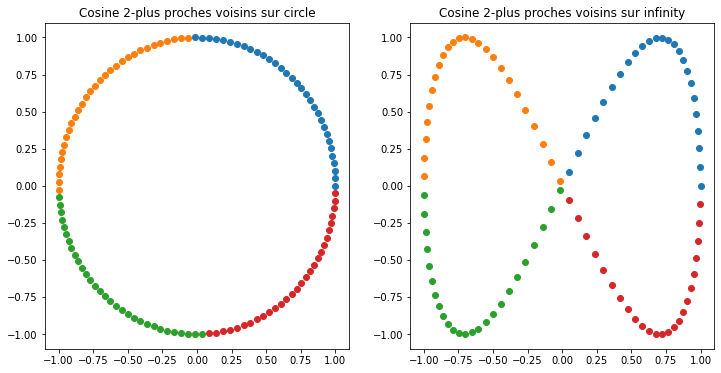

In [15]:
knn = KNeighborsClassifier(n_neighbors=2, metric='precomputed', algorithm='brute')
knn.fit(circle_cosine_dissimilarity, quadrants)

knn_circle = knn.predict(circle_cosine_dissimilarity)
knn_infinity = knn.predict(infinity_circle_cosine_dissimilarity)

fig = plt.figure(figsize=(12, 6))
circle_ax = fig.add_subplot(121)
infinity_ax = fig.add_subplot(122)
circle_ax.set_title('Cosine 2-plus proches voisins sur circle')
infinity_ax.set_title('Cosine 2-plus proches voisins sur infinity')

for i in range(4):
    circle_cluster = circle[np.where(knn_circle == i)[0]]
    circle_ax.scatter(circle_cluster[:, 0], circle_cluster[:, 1])
    
    infinity_cluster = infinity[np.where(knn_infinity == i)[0]]
    infinity_ax.scatter(infinity_cluster[:, 0], infinity_cluster[:, 1])